In [16]:
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context
# from google.colab import drive
# drive.mount("/content/gdrive")
pre_path =  ""#'/content/gdrive/My Drive/AN2DL_HW2/'

In [17]:
from IPython.display import display, HTML
display(HTML("<style>:root { --jp-notebook-max-width: 80% !important; }</style>"))

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
import logging
import random

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
import cv2
from statsmodels.tsa.stattools import acf

# Setting seeds for reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Suppressing unnecessary warnings and logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

print(tf.__version__)

# Additional imports for the model
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization, GlobalAveragePooling1D, GlobalMaxPooling1D, Activation,Input,Add


2.15.0


In [18]:
X_train = np.load(pre_path + 'normalized_data/normalized_test_X.npy',allow_pickle='TRUE').item()
y_train = np.load(pre_path +'normalized_data/normalized_train_y.npy',allow_pickle='TRUE').item()

X_validation = np.load(pre_path +'normalized_data/normalized_validation_X.npy',allow_pickle='TRUE').item()
y_validation = np.load(pre_path +'normalized_data/normalized_validation_y.npy',allow_pickle='TRUE').item()

X_test = np.load(pre_path +'normalized_data/normalized_test_X.npy',allow_pickle='TRUE').item()
y_test = np.load(pre_path +'normalized_data/normalized_test_y.npy',allow_pickle='TRUE').item()

In [19]:
window = 206
output_shape = 18
training_categories = ['A']
X_train = np.concatenate([X_train[i] for i in training_categories]).reshape(-1,window,1)
y_train = np.concatenate([y_train[i] for i in training_categories])

X_validation = np.concatenate([X_validation[i] for i in training_categories]).reshape(-1,window,1)
y_validation = np.concatenate([y_validation[i] for i in training_categories])

#X_test = np.concatenate([X_test[i] for i in training_categories]).reshape(-1,window,1)
#y_test = np.concatenate([y_test[i] for i in training_categories])

# resnet + conv + Dense

In [20]:
import tensorflow as tf
from tensorflow.keras import layers, models

def residual_block(x, filters, kernel_size=3, stride=1):
    y = layers.Conv1D(filters, kernel_size=kernel_size, strides=stride, padding='same')(x)
    y = layers.BatchNormalization()(y)
    y = layers.ReLU()(y)

    y = layers.Conv1D(filters, kernel_size=kernel_size, padding='same')(y)
    y = layers.BatchNormalization()(y)

    # If the number of filters is different or the stride is not 1, add a convolutional layer to the shortcut
    if stride != 1 or x.shape[-1] != filters:
        x = layers.Conv1D(filters, kernel_size=1, strides=stride, padding='same')(x)
        x = layers.BatchNormalization()(x)

    out = layers.add([x, y])
    out = layers.ReLU()(out)
    return out

def build_resnet(input_shape, num_classes=1):
    input_layer = layers.Input(shape=input_shape)

    # Initial convolutional layer
    x = layers.Conv1D(32, kernel_size=3, strides=1, padding='same')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)


    x = residual_block(x, filters=32, stride=1)
    x = MaxPooling1D(pool_size=2)(x)

    x = residual_block(x, filters=64, stride=1)
    x = MaxPooling1D(pool_size=2)(x)


    x = residual_block(x, filters=64, stride=1)
    x = MaxPooling1D(pool_size=2)(x)

    x = residual_block(x, filters=128, stride=1)
    x = MaxPooling1D(pool_size=2)(x)

    x = residual_block(x, filters=128, stride=1)
    x = MaxPooling1D(pool_size=2)(x)

    x = residual_block(x, filters=256, stride=1)
    x = MaxPooling1D(pool_size=2)(x)

    x = residual_block(x, filters=256, stride=1)
    x = layers.GlobalAveragePooling1D()(x)

    output_layer = Dense(18)(x)


    model = models.Model(inputs=input_layer, outputs=output_layer)
    return model

# Define the input shape (adjust according to your data)
input_shape = (window, 1)

# Build the model
model = build_resnet(input_shape)

# Compile the model (customize the optimizer, loss, and metrics based on your task)
model.compile(optimizer=tf.optimizers.legacy.Adam(), loss='mean_squared_error')

# Print the model summary
model.summary()


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 206, 1)]             0         []                            
                                                                                                  
 conv1d_94 (Conv1D)          (None, 206, 32)              128       ['input_6[0][0]']             
                                                                                                  
 batch_normalization_92 (Ba  (None, 206, 32)              128       ['conv1d_94[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 re_lu_75 (ReLU)             (None, 206, 32)              0         ['batch_normalization_92

# Full convolutional model

In [21]:
import tensorflow as tf
from tensorflow.keras import layers, models

def residual_block(x, filters, kernel_size=3, stride=1):
    y = layers.Conv1D(filters, kernel_size=kernel_size, strides=stride, padding='same')(x)
    y = layers.BatchNormalization()(y)
    y = layers.ReLU()(y)

    y = layers.Conv1D(filters, kernel_size=kernel_size, padding='same')(y)
    y = layers.BatchNormalization()(y)

    # If the number of filters is different or the stride is not 1, add a convolutional layer to the shortcut
    if stride != 1 or x.shape[-1] != filters:
        x = layers.Conv1D(filters, kernel_size=1, strides=stride, padding='same')(x)
        x = layers.BatchNormalization()(x)

    out = layers.add([x, y])
    out = layers.ReLU()(out)
    return out

def build_resnet(input_shape, num_classes=1):
    input_layer = layers.Input(shape=input_shape)

    # Initial convolutional layer
    x = layers.Conv1D(32, kernel_size=3, strides=1, padding='same')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Residual blocks
    x = residual_block(x, filters=64, stride=1)
    x = MaxPooling1D(pool_size=2,padding = 'same')(x)


    x = residual_block(x, filters=64, stride=1)
    x = MaxPooling1D(pool_size=2,padding = 'same')(x)

    x = residual_block(x, filters=128, stride=1)
    x = MaxPooling1D(pool_size=2,padding = 'same')(x)

    x = residual_block(x, filters=128, stride=1)
    x = MaxPooling1D(pool_size=2,padding = 'same')(x)


    x = residual_block(x, filters=64, stride=1)
    x = MaxPooling1D(pool_size=2,padding = 'same')(x)

    x = residual_block(x, filters=64, stride=1)
    x = MaxPooling1D(pool_size=2,padding = 'same')(x)

    x = residual_block(x, filters=32, stride=1)
    x = MaxPooling1D(pool_size=2,padding = 'same')(x)

    x = layers.Conv1D(18, kernel_size=3, strides=1, padding='same')(x)

    # Global average pooling
    output_layer = layers.GlobalAveragePooling1D()(x)


    model = models.Model(inputs=input_layer, outputs=output_layer)
    return model

# Define the input shape (adjust according to your data)
input_shape = (window, 1)

# Build the model
model = build_resnet(input_shape)

# Compile the model (customize the optimizer, loss, and metrics based on your task)
model.compile(optimizer=tf.optimizers.legacy.Adam(), loss='mean_squared_error')

# Print the model summary
model.summary()


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 206, 1)]             0         []                            
                                                                                                  
 conv1d_112 (Conv1D)         (None, 206, 32)              128       ['input_7[0][0]']             
                                                                                                  
 batch_normalization_110 (B  (None, 206, 32)              128       ['conv1d_112[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 re_lu_90 (ReLU)             (None, 206, 32)              0         ['batch_normalization_11

# Training

In [22]:
batch_size = 2**11
epochs = 5
with tf.device('gpu'):
    history = model.fit(
        x = X_train,
        y = y_train,
        batch_size = batch_size,
        epochs = epochs,
        validation_data=(X_validation, y_validation),
        callbacks = [
            tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=6, restore_best_weights=True),
            tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=2, factor=0.9, min_lr=1e-6)
        ]
    ).history

ValueError: Data cardinality is ambiguous:
  x sizes: 41143
  y sizes: 70877184
Make sure all arrays contain the same number of samples.

In [ ]:
#test_loss = model.evaluate(X_test, y_test,batch_size = batch_size)

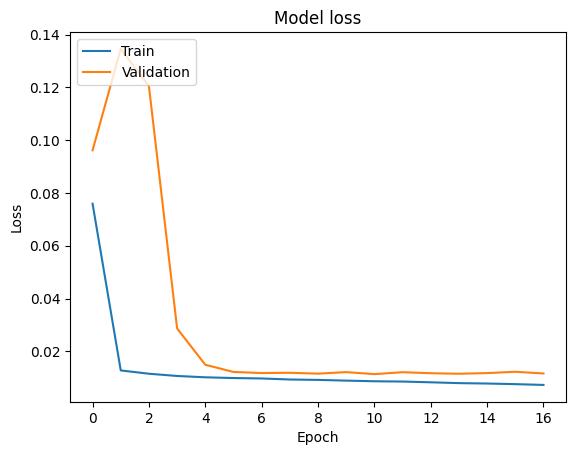

In [ ]:
plt.figure()
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
model.save(pre_path + 'models/model_normalized.h5')